# Average East Fitness Usage

In [4]:
# on windows
!dir | find "data"

11/12/2021  12:28 PM            25,200 usage_data.csv
11/12/2021  12:28 PM            48,067 usage_data_20.csv
11/12/2021  12:28 PM           234,891 usage_data_week_11_1.csv


In [5]:
# on linux
!ls | grep "data"

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf

cf.go_offline()

df = pd.read_csv("usage_data_week_11_1.csv", index_col=0)
df.head()

,name,current_capacity,total_capacity,percent_capacity,date_time
0,Upper Track (4th Floor),0.0,100.0,0.0,1.635758e+09
1,Faculty/Staff Workout Area,0.0,50.0,0.0,1.635758e+09
2,Upper Fitness,1.0,100.0,1.0,1.635758e+09
3,Upper Gym,29.0,100.0,29.0,1.635758e+09
4,MAC Court (Cardio),1.0,100.0,1.0,1.635758e+09


In [7]:
# Initialize pandas datetime object from UTC epoch seconds recorded
df.loc[:, 'date_time'] = pd.to_datetime(df.loc[:,'date_time'],unit="s",utc=True)
df.loc[:, 'date_time'] = df.date_time.dt.tz_convert('EST')

# corec isn't open at 4, same data as the previous day
df.loc[df.date_time.dt.hour == 4, 'current_capacity'] = 0  
# encoded wrong
df = df.reset_index(drop=True)

df.loc[(df.name == 'Upper Gym'),:]

,name,current_capacity,total_capacity,percent_capacity,date_time
3,Upper Gym,0.0,100.0,29.0,2021-11-01 04:05:07.539876608-05:00
31,Upper Gym,29.0,100.0,29.0,2021-11-01 05:05:07.283586816-05:00
59,Upper Gym,0.0,100.0,0.0,2021-11-01 06:05:07.473886464-05:00
87,Upper Gym,1.0,100.0,1.0,2021-11-01 07:05:10.592350464-05:00
115,Upper Gym,0.0,100.0,0.0,2021-11-01 08:05:07.798438144-05:00
...,...,...,...,...,...
4119,Upper Gym,42.0,100.0,42.0,2021-11-08 19:05:08.199793152-05:00
4147,Upper Gym,51.0,100.0,51.0,2021-11-08 20:05:10.278596608-05:00
4175,Upper Gym,56.0,100.0,57.0,2021-11-08 21:05:07.871051520-05:00
4203,Upper Gym,42.0,100.0,42.0,2021-11-08 22:05:07.597391360-05:00


In [8]:
eastdf = df.loc[df["name"] == 'East Fitness (Strength Equipment)'].copy()
eastdf.loc[:,'hour'] = eastdf.date_time.dt.hour
eastdf.loc[:,'day'] = eastdf.date_time.dt.day
eastdf.loc[:,'weekday'] = eastdf.date_time.dt.weekday
eastdf.loc[:,'weekday_name'] = eastdf.date_time.dt.day_name()


eastdf.head()

,name,current_capacity,total_capacity,percent_capacity,date_time,hour,day,weekday,weekday_name
20,East Fitness (Strength Equipment),0.0,300.0,3.0,2021-11-01 04:05:07.539876608-05:00,4,1,0,Monday
48,East Fitness (Strength Equipment),9.0,300.0,3.0,2021-11-01 05:05:07.283586816-05:00,5,1,0,Monday
76,East Fitness (Strength Equipment),37.0,300.0,13.0,2021-11-01 06:05:07.473886464-05:00,6,1,0,Monday
104,East Fitness (Strength Equipment),40.0,300.0,14.0,2021-11-01 07:05:10.592350464-05:00,7,1,0,Monday
132,East Fitness (Strength Equipment),49.0,300.0,17.0,2021-11-01 08:05:07.798438144-05:00,8,1,0,Monday


<AxesSubplot:xlabel='weekday'>

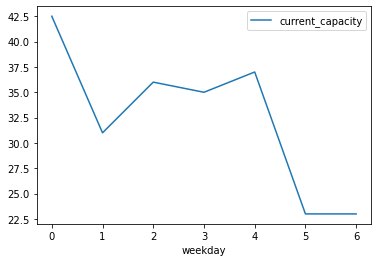

In [9]:
weekday = eastdf.groupby('weekday').median().reset_index()
weekday.plot(x='weekday', y='current_capacity')

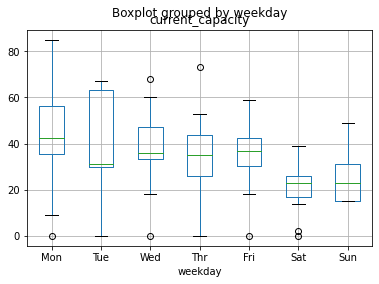

In [10]:
plot = eastdf.boxplot('current_capacity',by='weekday')
plot = plot.set_xticklabels(["Mon","Tue","Wed","Thr","Fri","Sat","Sun"])

<AxesSubplot:title={'center':'current_capacity'}, xlabel='hour'>

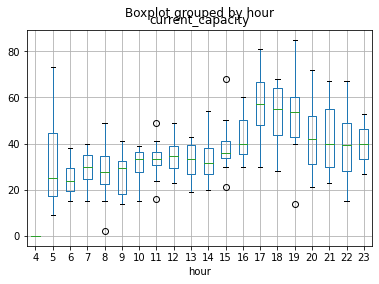

In [11]:
# hour = eastdf.groupby('hour')
# hour.plot(x='hour', y='current_capacity')
eastdf.boxplot('current_capacity',by='hour')

In [12]:
fig = eastdf.iplot(kind='scatter',
                     x = 'date_time',
                     y = 'current_capacity',
                     asFigure=True)
fig.update_traces(mode='lines+markers')

In [13]:
eastdf = eastdf.loc[eastdf.hour != 4,:]
eastdf.iplot(kind='scatter3d', x='hour', y = 'weekday', z='current_capacity', asFigure=True)




In [14]:
# separate train test
from sklearn.model_selection import train_test_split
train, test = train_test_split(eastdf.copy(), random_state=0)
test.sort_values(by='date_time', inplace = True)
train.sort_values(by='date_time', inplace = True)

In [15]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors = 3)
fitdf = train.loc[:,['weekday', 'hour']].copy()
regressor.fit(fitdf, train.loc[:,'current_capacity'])
predicted_train = []
predicted_train = regressor.predict(fitdf)
# for i in range(len(predicted)):
#     print(train.current_capacity.to_list()[i], predicted_train[i])
# regressor.score(test.loc[:,['weekday','hour']], test.loc[:,'current_capacity'])
test_predict = regressor.predict(test.loc[:,['weekday','hour']])
print(test_predict)
test['predicted'] = pd.Series(test_predict, index = test.index)
print('Score on train',regressor.score(fitdf, train.current_capacity))
print('Score on test',regressor.score(test.loc[:,['weekday','hour']], test.current_capacity))

[37.         39.33333333 45.66666667 53.33333333 15.66666667 32.33333333
 35.33333333 37.66666667 37.33333333 59.         21.         34.
 30.33333333 30.33333333 44.33333333 52.66666667 45.66666667 29.
 35.         37.66666667 31.         24.66666667 31.         39.
 47.66666667 27.         25.66666667 18.66666667 28.         25.66666667
 14.66666667 31.66666667 34.         39.66666667 63.33333333 53.33333333
 55.33333333]
Score on train 0.7201746388758861
Score on test 0.3492226698421165


Using regressor.score, which is bigger is better, 1.0 best. If it predicted the mean every time it would get a 0.0, so we're 0.3 better than an average.

In [16]:
px.scatter_3d(test, x='hour', y='weekday', z='predicted')

In [17]:
px.scatter_3d(test, x='hour', y='weekday', z='current_capacity')

In [18]:
px.line(test, x='date_time', y=['current_capacity','predicted'])

In [19]:
from datetime import datetime as dt
dt_now = dt.now()
now = pd.DataFrame({'weekday':[dt_now.weekday()], 'hour':[dt_now.hour + 1]})
regressor.predict(now)

array([44.33333333])

## below are attempts to plot side by sid 3d plots
(and surface contour plots)

As far as I can tell, you need to use real plotly, not express, which can be harder to use (you need to pass list-likes instead of column names, for example)

In [20]:
# fig = go.Figure(data=[go.Surface(z=test.current_capacity),y=test.hour,x=test.weekday])
# fig.update_layout(title='Mt Bruno Elevation', autosize=True,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.show()

In [21]:
from plotly import subplots
import plotly.graph_objs as go
type(go.Scatter3d(x=[1,2,3], y=[2,1,2], z=[2,1,2]))

plotly.graph_objs._scatter3d.Scatter3d

In [22]:
fig = subplots.make_subplots(rows=1, cols = 2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])
# fig.append_trace(px.scatter_3d(test, x='hour', y='weekday', z='current_capacity'),
#                 row = 1, col = 1)
fig.add_traces(px.scatter_3d(test, x='hour', y='weekday', z='predicted')
                )
fig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'hovertemplate': 'hour=%{x}<br>weekday=%{y}<br>predicted=%{z}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([ 7, 12, 13, 21,  5,  9, 11, 13, 14, 20,  6,  9, 12, 13, 14, 19, 20,  5,
                          13, 14, 22,  9, 11, 16, 17, 22,  5,  6, 13, 20,  9, 13, 16,  8, 20, 21,
                          22], dtype=int64),
              'y': array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4,
                          4, 4, 5, 5, 5, 5, 6, 6, 6, 0, 0, 0, 0], dtype=int64),
              'z': array([37.        , 39.33333333, 45.66666667, 53.33333333, 15.66666667,
                          32.33333333, 35.33333333, 37.66666667, 37.33333333, 59.        ,
                          21.        , 34.        , 30.33333333, 30.33333333, 44.33333333,
                          52.66666667, 45.66666667, 29.        , 35.        , 37.66666667,
                          31.        , 24.66666667, 31.        , 39.        , 47.66666667,
                          27.        , 25.66666667, 18.66666667, 28.        , 25.66666667,
                          14.66666667, 31.66666667, 34.        , 39.66666667, 63.33333333,
                          53.33333333, 55.33333333])}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'scene': {'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
                         'xaxis': {'title': {'text': 'hour'}},
                         'yaxis': {'title': {'text': 'weekday'}},
                         'zaxis': {'title': {'text': 'predicted'}}},
               'template': '...'}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scatterternary', 'splom',
                     'streamtube', 'sunburst', 'surface', 'table',
                     'treemap', 'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [ ]:
import plotly.express as px
import plotly.subplots as sp

# Create figures in Express
figure1 = px.scatter_3d(test, x='hour', y='weekday', z='predicted')
figure2 = px.scatter_3d(test, x='hour', y='weekday', z='current_capacity')

# For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
# This is essentially breaking down the Express fig into it's traces
figure1_traces = []
figure2_traces = []
for trace in range(len(figure1["data"])):
    figure1_traces.append(figure1["data"][trace])
for trace in range(len(figure2["data"])):
    figure2_traces.append(figure2["data"][trace])

#Create a 1x2 subplot
this_figure = sp.make_subplots(rows=1, cols=2) 

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row=1, col=2)
this_figure

## Explore new api data

In [89]:
from IPython.display import display, HTML

full_api_df = pd.read_csv('new_api.csv', index_col=0, header=0, nrows=20)
display(full_api_df.head())
new_df = pd.read_csv('new_api.csv', index_col=0, header=0,usecols=[0,1,3,6,7,16,17])
display(new_df)

,LocationId,TotalCapacity,LocationName,CountOfParticipants,PercetageCapacity,LastUpdatedDateAndTime,LastCount,MinColor,MidColor,MaxColor,MinCapacityRange,MaxCapacityRange,CountCapacityColorEnabled,FacilityId,FacilityName,IsClosed,time_retrived
0,6129,100,Upper Track (4th Floor),0,0,2021-11-16T18:25:48.663,1,#ffc90e,NaN,#ed1c24,60,90,True,976,Operations,False,1.637106e+09
1,5978,50,Faculty/Staff Workout Area,0,0,2021-11-16T18:25:49.133,0,#ffc90e,NaN,#ed1c24,60,90,True,976,Operations,False,1.637106e+09
2,5995,100,Upper Fitness,0,0,2021-11-16T18:25:49.57,13,#ffc90e,NaN,#ed1c24,60,90,True,976,Operations,False,1.637106e+09
3,5996,100,Upper Gym,0,0,2021-11-16T18:25:50.007,30,#ffc90e,NaN,#ed1c24,60,90,True,976,Operations,False,1.637106e+09
4,6130,100,MAC Court (Cardio),0,0,2021-11-16T18:25:50.43,0,#ffc90e,NaN,#ed1c24,60,90,True,976,Operations,False,1.637106e+09


,LocationId,LocationName,LastUpdatedDateAndTime,LastCount,IsClosed,time_retrived
0,6129,Upper Track (4th Floor),2021-11-16T18:25:48.663,1,False,1.637106e+09
1,5978,Faculty/Staff Workout Area,2021-11-16T18:25:49.133,0,False,1.637106e+09
2,5995,Upper Fitness,2021-11-16T18:25:49.57,13,False,1.637106e+09
3,5996,Upper Gym,2021-11-16T18:25:50.007,30,False,1.637106e+09
4,6130,MAC Court (Cardio),2021-11-16T18:25:50.43,0,False,1.637106e+09
...,...,...,...,...,...,...
23,6131,MP3 (Strength Equipment),2021-11-29T09:25:04.557,2,False,1.638198e+09
24,7291,Colby (Cardio),2021-11-29T09:25:04.87,6,False,1.638198e+09
25,7290,Colby (Strength),2021-11-29T09:25:05.227,57,False,1.638198e+09
26,5985,Lower Gym (Badminton & Pickleball),2021-11-29T09:25:05.557,0,False,1.638198e+09


In [90]:
print(new_df.dtypes)
new_df.loc[:,'LastUpdatedDateAndTime'] = pd.to_datetime(new_df.loc[:,'LastUpdatedDateAndTime']) \
                                        .dt.tz_localize('EST') # already in EST, but let the dt objects know that
print(new_df.LastUpdatedDateAndTime.dt.hour.head())
new_df.head()

LocationId                  int64
LocationName               object
LastUpdatedDateAndTime     object
LastCount                   int64
IsClosed                     bool
time_retrived             float64
dtype: object
0    18
1    18
2    18
3    18
4    18
Name: LastUpdatedDateAndTime, dtype: int64


,LocationId,LocationName,LastUpdatedDateAndTime,LastCount,IsClosed,time_retrived
0,6129,Upper Track (4th Floor),2021-11-16 18:25:48.663000-05:00,1,False,1.637106e+09
1,5978,Faculty/Staff Workout Area,2021-11-16 18:25:49.133000-05:00,0,False,1.637106e+09
2,5995,Upper Fitness,2021-11-16 18:25:49.570000-05:00,13,False,1.637106e+09
3,5996,Upper Gym,2021-11-16 18:25:50.007000-05:00,30,False,1.637106e+09
4,6130,MAC Court (Cardio),2021-11-16 18:25:50.430000-05:00,0,False,1.637106e+09


In [91]:
# find the latest update:
new_df.describe()

,LocationId,LastCount,time_retrived
count,7056.000000,7056.000000,7.056000e+03
mean,6249.428571,6.533305,1.637653e+09
std,489.816180,13.064406,3.144147e+05
min,5960.000000,0.000000,1.637106e+09
25%,5980.500000,0.000000,1.637377e+09
50%,5993.500000,1.000000,1.637653e+09
75%,6138.250000,7.000000,1.637929e+09
max,7293.000000,125.000000,1.638198e+09


In [92]:
new_east = new_df.loc[new_df['LocationName']=='East Fitness (Strength Equipment)',:].copy()
display(new_east)
new_east.iplot(kind='line', x='LastUpdatedDateAndTime', y='LastCount')

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_4084/1821099968.py, line 3)

In [93]:
new_east['time'] = new_east.loc[:,'LastUpdatedDateAndTime'].dt.time
new_east.iplot(kind = 'scatter', x='time', y= 'LastCount',mode = 'markers+lines')

In [94]:
new_east['weekday'] = new_east.LastUpdatedDateAndTime.dt.day_name()

time_sorted = new_east.sort_values(by='time')
time_sorted.head(n=20)

,LocationId,LocationName,LastUpdatedDateAndTime,LastCount,IsClosed,time_retrived,hour,weekday,time
20,5976,East Fitness (Strength Equipment),2021-11-17 06:04:11.163000-05:00,12,False,1.637147e+09,06:04:11.163000,Wednesday,06:04:11.163000
20,5976,East Fitness (Strength Equipment),2021-11-24 06:04:27.623000-05:00,5,False,1.637752e+09,06:04:27.623000,Wednesday,06:04:27.623000
20,5976,East Fitness (Strength Equipment),2021-11-24 06:04:27.623000-05:00,5,False,1.637756e+09,06:04:27.623000,Wednesday,06:04:27.623000
20,5976,East Fitness (Strength Equipment),2021-11-29 06:11:40.363000-05:00,25,False,1.638188e+09,06:11:40.363000,Monday,06:11:40.363000
20,5976,East Fitness (Strength Equipment),2021-11-22 06:11:59.950000-05:00,14,False,1.637583e+09,06:11:59.950000,Monday,06:11:59.950000
20,5976,East Fitness (Strength Equipment),2021-11-19 06:13:27.153000-05:00,11,False,1.637324e+09,06:13:27.153000,Friday,06:13:27.153000
20,5976,East Fitness (Strength Equipment),2021-11-18 06:14:19.553000-05:00,29,False,1.637237e+09,06:14:19.553000,Thursday,06:14:19.553000
20,5976,East Fitness (Strength Equipment),2021-11-23 06:22:28.177000-05:00,15,False,1.637669e+09,06:22:28.177000,Tuesday,06:22:28.177000
20,5976,East Fitness (Strength Equipment),2021-11-17 07:03:23.547000-05:00,35,False,1.637151e+09,07:03:23.547000,Wednesday,07:03:23.547000
20,5976,East Fitness (Strength Equipment),2021-11-19 07:09:55.650000-05:00,33,False,1.637327e+09,07:09:55.650000,Friday,07:09:55.650000


In [95]:
# new_east['time_of_day_sec'] = new_east.time.apply
# fig = px.scatter(new_east, x='time',y='LastCount',color='weekday',trendline='rolling', trendline_options=dict(window=5))
fig = px.scatter(new_east, x='LastUpdatedDateAndTime',y='LastCount',color='weekday')
fig.update_layout(xaxis=dict(type='category',categoryorder='category ascending'))
fig.show()

In [78]:
new_east.time.to_list()[0]

datetime.time(6, 4, 11, 163000)